# Installing packages

In [1]:
from urllib.request import urlopen
import urllib
import json
import numpy as np
import pandas as pd
from num2words import num2words
%load_ext rpy2.ipython

In [2]:
%%R  -w 8 -h 3 #--units in -r 200
##installing packages and setting options for the plots in R

# {r settings, echo=F, message=F, error=F}
knitr::opts_chunk$set(echo = F)
if (!require("pacman")) install.packages("pacman")
pacman::p_load(ggplot2, patchwork, cowplot, tidyverse, devtools, ggrepel, ggh4x, officer, rvg, svglite, install = T)

# # Required on the first run, comment afterward?
devtools::install_github("BlakeRMills/MoMAColors")
library(MoMAColors)

theme_set(theme_cowplot() +
          theme(text = element_text(size=9),
                axis.text = element_text(size=9),
                panel.grid.major.x = element_blank() ,
                panel.grid.major.y = element_line( linewidth=.1, color="black")))

Loading required package: pacman
Skipping install of 'MoMAColors' from a github remote, the SHA1 (6f5d75de) has not changed since last install.
  Use `force = TRUE` to force installation


# Define functions to get the frequencies of number for a given language

In [3]:
def get_list_from_ngram(words, lang="en", year_start=1950, year_end=2000):
  """
  Given a list of words, get the data from google ngram, parse it as json,
  and return the python object. We ask for the whole list at once to avoid
  the "too many requests" issues
  """
  request = ",".join(words)
  request = urllib.parse.quote_plus(request)
  url = f"https://books.google.com/ngrams/json?content={request}&year_start={year_start}&year_end={year_end}&corpus={lang}-2019&smoothing=0"
  return json.loads(urlopen(url).read())

In [4]:
def populate_one_lang(lang, min=1, max=100):
  # Generate word list, then fetch data for each word
  numbers = list(range(min, max))
  if lang == "fr":
    # Damned be French with its _four words_ expression for these numbers!
    numbers.remove(97)
    numbers.remove(98)
    numbers.remove(99)
  data = pd.DataFrame({"number": numbers})
  data["lang"] = lang
  data["word"] = [num2words(number, lang=lang) for number in data["number"]]
   
  # Fetch NGRAM data
  replies = get_list_from_ngram(data["word"], lang=lang)

  # Read through json and extract avg. freq, as well as the word that NGRAM
  # gives us a value for (e.g. "forty-two" gets normalized on their end as
  # "forty - two")
  # Also turn frequency into per nb of occurence per million: x 1000000
  data["mean_freq"] = [1000000*np.mean(reply["timeseries"]) for reply in replies]
  data["matched_word"] = [reply["ngram"] for reply in replies]

  # Create additional column to store the data for words with dash
  data["mean_dash_freq"] = 0

  data["has_dash"] = ["-" in word for word in data["word"]]

  # Turn dashes into spaces, make new request for those
  words_with_dash = data.loc[data["has_dash"], "word"]
  dash_replies = get_list_from_ngram([word.replace("-", " ") for word in words_with_dash], lang=lang)
  mean_dash_replies = [np.mean(reply["timeseries"]) for reply in dash_replies]
  data.loc[data["has_dash"], "mean_dash_freq"] += mean_dash_replies


  # Add all together
  data["mean_total_freq"] = data["mean_freq"]

  # Remove occurences whenever there's a substring: from "twenty" remove "twenty-one", "twenty-two", etc.

  data["corrected_total_freq"] = np.nan
  for i, row in data.iterrows():
    pattern = fr"\s{row['matched_word']}|\b{row['matched_word']}\s"
    row_is_substring = data["matched_word"].str.contains(pattern, regex=True)
    row_is_different = data["matched_word"] != row['matched_word']
    row_to_substract = row_is_substring & row_is_different
    total_to_remove = np.sum(data[row_to_substract]["mean_total_freq"])
    data.at[i,'corrected_total_freq'] = row["mean_total_freq"] - total_to_remove

  # Handle the special cases for the "unas"
  if lang in ['es', 'it']:
    problem_numbers = [i+1 for i in range(0, 100,10)]
    problem_rows = data[data['number'].isin(problem_numbers)]
    number_words = list(problem_rows['word'])
    feminin_number_words = [s[:-1] + 'a' if s.endswith('o') else s for s in number_words]
    replies_feminin = get_list_from_ngram(feminin_number_words, lang=lang)
    occurences_feminin = [1000000*np.mean(reply["timeseries"]) for reply in replies_feminin]
    for word, addition in zip(number_words, occurences_feminin):
      data.loc[data['word'] == word, 'corrected_total_freq'] += addition

  # Handle the special case for "one" in german
  if lang=='de':
    replies_ein = get_list_from_ngram(['ein', 'eine'], lang=lang)
    occurences_ein = [1000000*np.mean(reply["timeseries"]) for reply in replies_ein]
    data.loc[data['word'] == 'eins', 'corrected_total_freq'] += np.sum(occurences_ein)

  # Handle the special cases of one and two in russian
  if lang=='ru':
    replies_one = get_list_from_ngram(['одна','одно'], lang=lang)
    replies_two = get_list_from_ngram('две', lang=lang)
    occurences_one = [1000000*np.mean(reply["timeseries"]) for reply in replies_one]
    occurences_two = [1000000*np.mean(replies_two[0]["timeseries"])]
    data.loc[data['word'] == 'один', 'corrected_total_freq'] += np.sum(occurences_one)
    data.loc[data['word'] == 'два', 'corrected_total_freq'] += np.sum(occurences_two)

  # The case for exactly and about, to use only for english
  data["about_word"] = ["about " + num2words(number, lang='en') for number in data["number"]]
  data["exactly_word"] = ["exactly " + num2words(number, lang='en') for number in data["number"]]
   
  replies_about = get_list_from_ngram(data["about_word"], lang='en')
  replies_exactly = get_list_from_ngram(data["exactly_word"], lang='en')

  data["mean_freq_about"] = [1000000*np.mean(reply["timeseries"]) for reply in replies_about]
  data["mean_freq_exactly"] = [1000000*np.mean(reply["timeseries"]) for reply in replies_exactly]

  data["log_freq_about"] = np.log10(data["mean_freq_about"])
  data["log_freq_exactly"] = np.log10(data["mean_freq_exactly"])

  
  # Do both possibilities for vizualisation later, default is corrected
  data["log_freq"] = np.log10(data["corrected_total_freq"])
  data["log_freq_uncorrected"] = np.log10(data["mean_total_freq"])
   
  return data

In [7]:
def frequency_arabic_numbers(lang='en', min=1, max=100):
    numbers = list(range(min, max))
    data = pd.DataFrame({"number": numbers})
    data["lang"] = lang + '_arabic_numerals'
    data["arabic_number"] = [str(number) for number in data["number"]]

    replies = get_list_from_ngram(data["arabic_number"], lang=lang)
    data["mean_freq"] = [1000000*np.mean(reply["timeseries"]) for reply in replies]
    data["log_freq"] = np.log10(data["mean_freq"])

    # Basically useless but just for ease of analysis later
    data["mean_freq_about"] = [1] * (max-min)
    data["mean_freq_exactly"] = [1] * (max-min)
    data["log_freq_about"] = np.log10(data["mean_freq_about"])
    data["log_freq_exactly"] = np.log10(data["mean_freq_exactly"])


    return data

# Get frequencies for all languages

In [8]:
langs = ["en", "fr", "it", "de", "es", 'ru']
data = pd.concat([populate_one_lang(lang,min=1,max=100) for lang in langs])

mean_data = data[data.lang.isin(['en'])].copy()
mean_data.lang = 'mean'
langs = list(data.lang.unique())
langs.remove('en')
for lang in langs:
    mean_data.log_freq += data[data.lang.isin([lang])]['log_freq']

mean_data.log_freq = mean_data.log_freq/(len(langs)+1)

data = pd.concat([data, mean_data], axis=0)
data.dropna(inplace=True, axis=0)

arabic_numbers_data = frequency_arabic_numbers()
data = pd.concat([data, arabic_numbers_data], axis=0)

/var/folders/ww/jwc_dkyx4_58jw9lnh79r69r0000gn/T/ipykernel_5469/4268573339.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.15151340e-07 7.73518548e-08 6.82363359e-08 1.64571087e-07
 2.76267412e-07 5.63028375e-08 5.18306470e-08 5.67944659e-08
 3.08093206e-08 3.82160609e-08 5.18160362e-08 4.20748450e-08
 3.13230047e-08 8.80407873e-08 5.10641919e-08 3.17951938e-08
 2.88632421e-08 2.25689463e-08 2.25905582e-08 2.69906697e-08
 2.15930634e-08 2.18464602e-08 5.78065004e-08 1.93834200e-08
 1.98288307e-08 3.65851757e-08 1.83241007e-08 2.72975205e-08
 2.81352782e-08 2.18220111e-08 2.18371247e-08 2.66102365e-08
 1.93984840e-08 1.66222219e-08 1.56454891e-08 1.24987155e-08
 1.70622480e-08 1.78739303e-08 1.83425914e-08 2.16521358e-08
 3.29212337e-08 1.42584817e-08 1.35582411e-08 1.39378288e-08
 1.07808172e-08 1.29720423e-08 2.01807668e-08 1.33977343e-08
 1.27996154e-08 6.05275781e-08 1.38531520e-08 1.22573742e

In [9]:
## get the exponents and divisiblities of all numbers by certain integers for future analysis
def exponent_in_factorization(n, i):
    exponent = 0
    while n % i == 0:
        exponent += 1
        n //= i
    return exponent


data["mult10"] = ((data["number"] % 10)==0)
data["mult7"] = ((data["number"] % 7)==0)
data["mult5"] = ((data["number"] % 5)==0)
data["mult3"] = ((data["number"] % 3)==0)
data["mult2"] = ((data["number"] % 2)==0)

data["mult2"] = data["mult2"].apply(lambda x:int(x))
data["mult3"] = data["mult3"].apply(lambda x:int(x))
data["mult5"] = data["mult5"].apply(lambda x:int(x))
data["mult7"] = data["mult7"].apply(lambda x:int(x))
data["mult10"] = data["mult10"].apply(lambda x:int(x))


data["exp2"] = [ exponent_in_factorization(n,2) for n in data["number"] ]
data["exp3"] = [ exponent_in_factorization(n,3) for n in data["number"] ]
data["exp5"] = [ exponent_in_factorization(n,5) for n in data["number"] ]
data["exp7"] = [ exponent_in_factorization(n,7) for n in data["number"] ]
data["exp10"] = [ exponent_in_factorization(n,10) for n in data["number"] ]

data['log10'] = data.number.apply(lambda x: np.log10(x))

In [10]:
# saving the data
data.to_csv('data_ngram_allLangsPerMilion.csv')

# Plotting frequencies for all languages

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 99 rows containing missing values or values outside the scale range
(`geom_line()`). 



In addition: Warning message:
Removed 99 rows containing missing values or values outside the scale range
(`geom_line()`). 


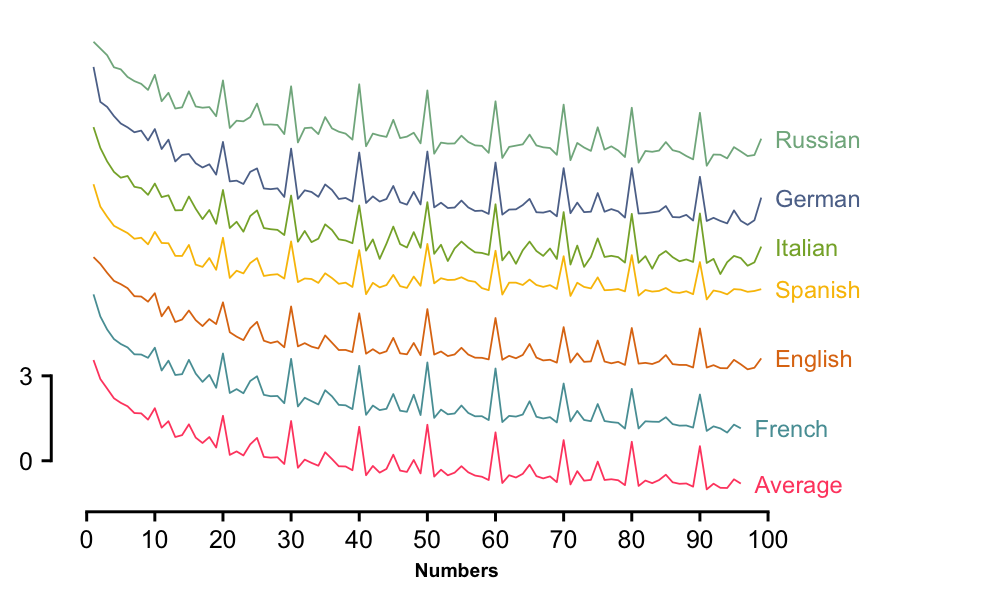

In [5]:
%%R -w 5 -h 3 --units in -r 200

pl1 <-
  read.csv("data_ngram_allLangsPerMilion.csv") %>%
  mutate(nicelang =
         case_when(
          lang == "mean" ~ "Average",
          lang == "fr" ~ "French",
          lang == "en" ~ "English",
          lang == "it" ~ "Italian",
          lang == "de" ~ "German",
          lang == "es" ~ "Spanish",
          lang == "ru" ~ "Russian",
          
          )) %>%
  mutate(nicelang = factor(nicelang, levels=c('Average',"French", "English", "Spanish", "Italian", "German", "Russian"))) %>%
  filter(number > 0, number < 100) %>%
  group_by(nicelang) %>%
  mutate(label = if_else(number == max(number), as.character(nicelang), NA_character_)) %>%
  ungroup %>%
  ggplot(aes(x = number, y = 2*(as.numeric(nicelang)-1) + log_freq, color=nicelang, group=nicelang)) +
  geom_line(linewidth=0.3) +
  geom_text_repel(aes(label = label), size=3, nudge_x = 4, na.rm = TRUE) +
  theme(legend.position = "none",
      axis.title.y=element_blank(),
      panel.grid.major.y = element_blank(),
      axis.title.x = element_text(face="bold", size=7, hjust=0.43, family='Arial')) +
  labs(x = "Numbers") +
  scale_color_manual(values=moma.colors("Klein")) +
  xlim(1,125) +
  guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
         y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

ggsave(filename = "plots/1_freqs_all_languages.svg", device='svg', plot = pl1, width = 5, height = 3)
pl1

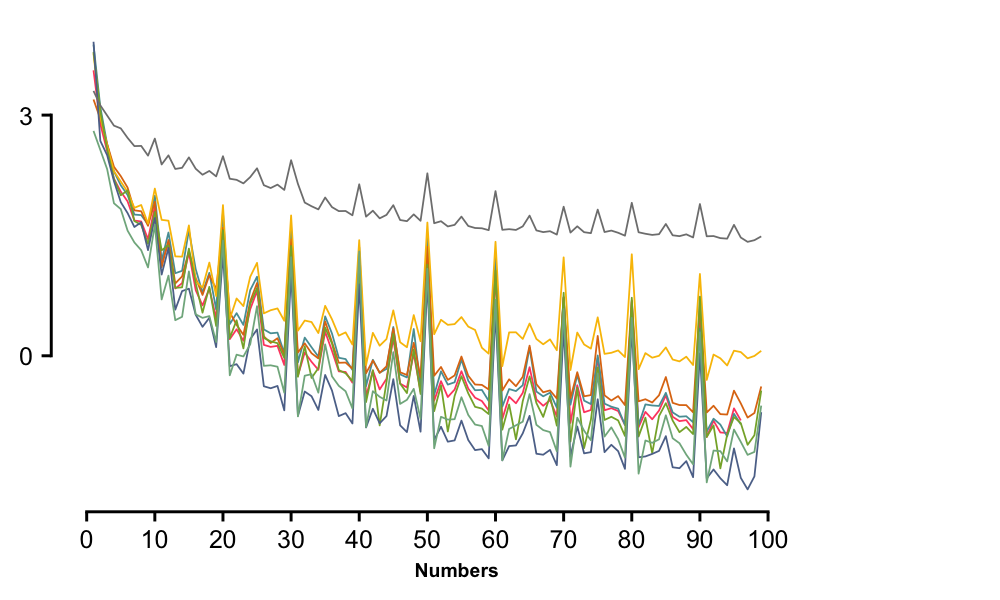

In [4]:
%%R -w 5 -h 3 --units in -r 200

pl1 <-
  read.csv("data_ngram_allLangsPerMilion.csv") %>%
  mutate(nicelang =
         case_when(
          lang == "mean" ~ "Average",
          lang == "fr" ~ "French",
          lang == "en" ~ "English",
          lang == "it" ~ "Italian",
          lang == "de" ~ "German",
          lang == "es" ~ "Spanish",
          lang == "ru" ~ "Russian",
          
          )) %>%
  mutate(nicelang = factor(nicelang, levels=c('Average',"French", "English", "Spanish", "Italian", "German", "Russian"))) %>%
  filter(number > 0, number < 100) %>%
  group_by(nicelang) %>%
  mutate(label = if_else(number == max(number), as.character(nicelang), NA_character_)) %>%
  ungroup %>%
  ggplot(aes(x = number, y = log_freq, color=nicelang, group=nicelang)) +
  geom_line(linewidth=0.3) +
#   geom_text_repel(aes(label = label), size=3, nudge_x = 4, na.rm = TRUE) +
  theme(legend.position = "none",
      axis.title.y=element_blank(),
      panel.grid.major.y = element_blank(),
      axis.title.x = element_text(face="bold", size=7, hjust=0.43, family='Arial')) +
  labs(x = "Numbers") +
  scale_color_manual(values=moma.colors("Klein")) +
  xlim(1,125) +
  guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
         y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

# ggsave(filename = "plots/1_freqs_all_languages.svg", device='svg', plot = pl1, width = 5, height = 3)
pl1

# Plotting frequencies for English words and English numerals

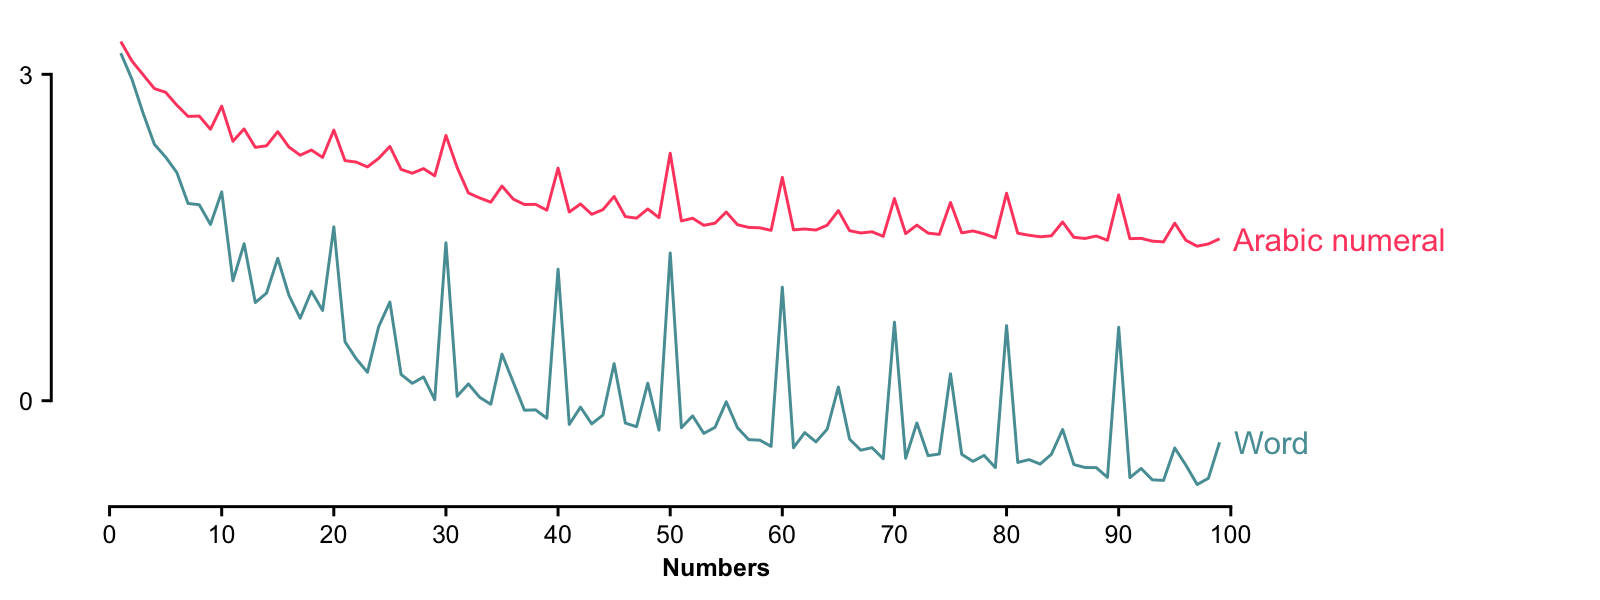

In [12]:
%%R -w 8 -h 3 --units in -r 200

pl1 <-
  read.csv("data_ngram_allLangsPerMilion.csv") %>%
  filter(lang %in% c('en', 'en_arabic_numerals')) %>%
  mutate(nicelang =
         case_when(
          lang == "en_arabic_numerals" ~ "Arabic numeral",
          lang == "en" ~ "Word",
   
          
          )) %>%
  mutate(nicelang = factor(nicelang, levels=c('Arabic numeral', "Word"))) %>%
  filter(number > 0, number < 100) %>%
  group_by(nicelang) %>%
  mutate(label = if_else(number == max(number), as.character(nicelang), NA_character_)) %>%
  ungroup %>%
  ggplot(aes(x = number, y = log_freq, color=nicelang, group=nicelang)) +
  geom_line(linewidth=0.5) +
  geom_text_repel(aes(label = label), size=4, nudge_x = 4, na.rm = TRUE) +
  theme(legend.position = "none",
      axis.title.y=element_blank(),
      panel.grid.major.y = element_blank(),
      axis.title.x = element_text(face="bold", size=9, hjust=0.43, family='Arial')) +
  labs(x = "Numbers") +
  scale_color_manual(values=moma.colors("Klein")) +
  xlim(1,125) +
  guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
         y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

ggsave(filename = "plots/S2_freqs_words_numerals.svg", device='svg', plot = pl1, width = 8, height = 3)
pl1

# Comparing uncorrected and corrected frequencies

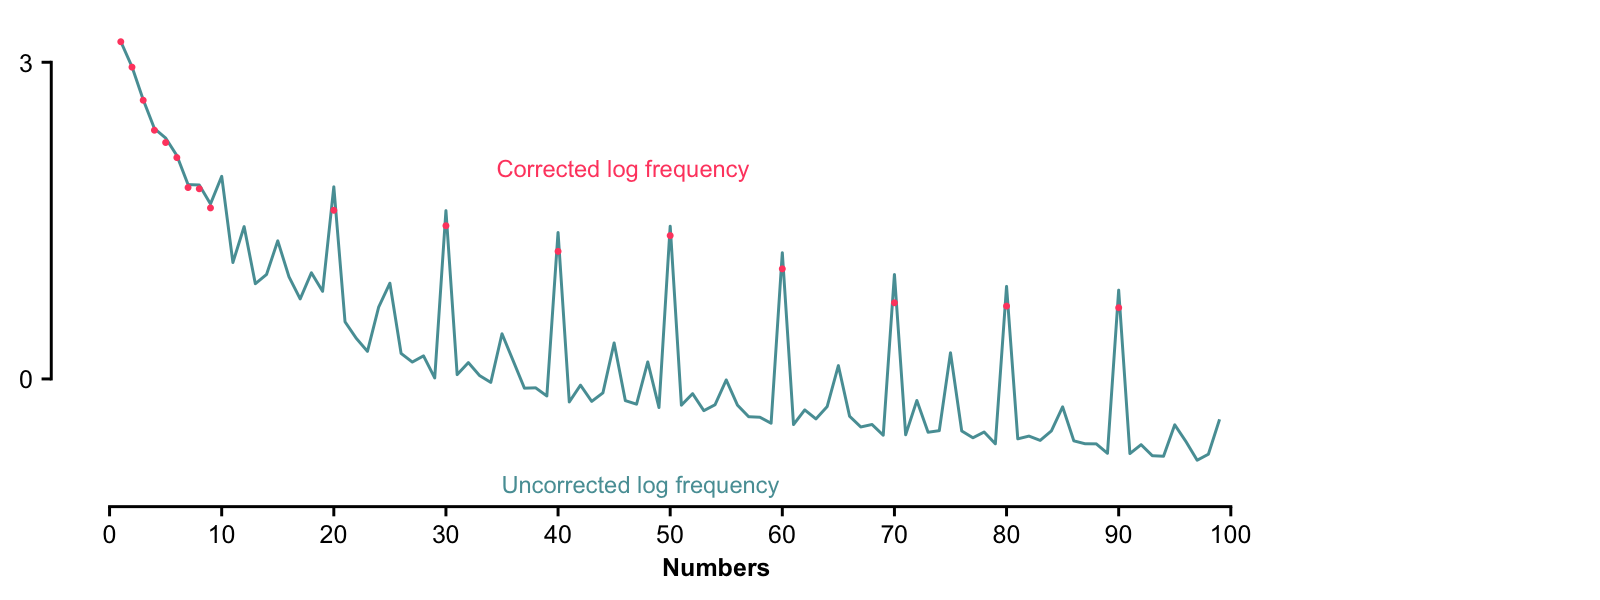

In [4]:
%%R  -w 8 -h 3 --units in -r 200

plsup1 <- read.csv('data_ngram_allLangsPerMilion.csv') %>%
    filter(lang %in% c('en')) %>%

    ggplot(aes(x = number)) +
    


    geom_line(
    aes(y = log_freq_uncorrected, color='point'), linewidth=0.5) +
    geom_point(data = . %>% filter(log_freq_uncorrected != log_freq),aes(y = log_freq, color='line'),size=0.5) +
    geom_text(data = . %>% filter(number == 30), 
            aes(x = number, y = 2, label = 'Corrected log frequency', color = 'line'), 
            hjust = -0.2, size = 3) +   # Label for first line
    geom_text(data = . %>% filter(number == 30), 
            aes(x = number, y = -1, label = 'Uncorrected log frequency', color = 'point'), 
            hjust = -0.2, size = 3) +   # Label for second line
    theme(legend.position = "none",
            axis.title.y=element_blank(),
            panel.grid.major.y = element_blank(),
            axis.title.x = element_text(face="bold", size=9, hjust=0.43, family='Arial')) +
    labs(x = "Numbers") +
    scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))


ggsave("plots/S1_corrected_vs_uncorrected_option2.svg", plsup1, device='svg',width = 8, height = 3, units = "in")

plsup1